# Post Position Study


In [5]:
# Setup Environment

# Setup Environment
import time
from optuna.importance import MeanDecreaseImpurityImportanceEvaluator
import os
import logging
import datetime
import numpy as np
import pandas as pd
import optuna
import optuna.visualization as viz
import pyspark.sql.functions as F
from pyspark.sql.functions import (col, count, row_number, abs, unix_timestamp, mean, 
                                   when, lit, min as F_min, max as F_max , upper, trim,
                                   row_number, mean as F_mean, countDistinct, last, first, when)
from src.data_preprocessing.data_prep1.data_utils import initialize_environment
from src.data_preprocessing.data_prep1.data_loader import load_data_from_postgresql

In [7]:
spark, jdbc_url, jdbc_properties, parquet_dir, log_file = initialize_environment()

Spark session created successfully.


In [188]:
def post_pos_queries():
    queries = {
        "post_pos_no_change": """
            SELECT 
                      r.course_cd , r.race_date , r.race_number , r.saddle_cloth_number , 
                      re.program_num , re.post_pos , r.post_position ,re.official_fin 
            FROM runners r
            LEFT JOIN results_entries re on r.course_cd = re.course_cd 
                AND r.race_date = re.race_date 
                AND r.race_number = re.race_number 
                AND r.saddle_cloth_number = re.program_num
            WHERE re.official_fin is not null
            AND re.official_fin <> 0
            AND re.post_pos = r.post_position
            AND r.course_cd in ('CNL','SAR','PIM','TSA','BEL','MVR',
                'TWO','CLS','KEE','TAM','TTP','TKD','ELP','PEN','HOU','DMR','TLS',
                'AQU','MTH','TGP','TGG','CBY','LRL','TED','IND','CTD','ASD','TCD',
                'LAD','TOP')
            """,
        "post_pos_change_up" : """
        SELECT 
              r.course_cd , r.race_date , r.race_number , r.saddle_cloth_number , re.program_num , re.post_pos , r.post_position ,re.official_fin 
        FROM runners r
        LEFT JOIN results_entries re on r.course_cd = re.course_cd 
            and r.race_date = re.race_date 
            and r.race_number = re.race_number 
            and r.saddle_cloth_number = re.program_num
        WHERE re.official_fin <> 0
        AND re.official_fin is not null 
        AND re.post_pos > r.post_position
        AND r.course_cd in ('CNL','SAR','PIM','TSA','BEL','MVR',
                'TWO','CLS','KEE','TAM','TTP','TKD','ELP','PEN','HOU','DMR','TLS',
                'AQU','MTH','TGP','TGG','CBY','LRL','TED','IND','CTD','ASD','TCD',
                'LAD','TOP')
        """,
        "post_pos_change_down" : """
        SELECT 
              r.course_cd , r.race_date , r.race_number , r.saddle_cloth_number , re.program_num , re.post_pos , r.post_position ,re.official_fin 
        FROM runners r
        LEFT JOIN results_entries re on r.course_cd = re.course_cd 
            and r.race_date = re.race_date 
            and r.race_number = re.race_number 
            and r.saddle_cloth_number = re.program_num
        WHERE re.official_fin <> 0
        AND re.official_fin is not null 
        AND re.post_pos < r.post_position
        AND r.course_cd in ('CNL','SAR','PIM','TSA','BEL','MVR',
                'TWO','CLS','KEE','TAM','TTP','TKD','ELP','PEN','HOU','DMR','TLS',
                'AQU','MTH','TGP','TGG','CBY','LRL','TED','IND','CTD','ASD','TCD',
                'LAD','TOP')
        """,
        "predictions":"""
        SELECT  p.course_cd,
                p.race_date,
                p.race_number,
                p.saddle_cloth_number,
                r.post_position,
                "YetiRank_top_3_NDCG_top_4_score",
                "YetiRank_top_3_NDCG_top_4_score_pos",
                "YetiRank_top_3_NDCG_top_4_rank"
        FROM predictions_20250320_161052_1 p
        JOIN runners r on p.course_cd = r.course_cd 
        AND p.race_date = r.race_date 
        AND p.race_number = r.race_number 
        AND p.saddle_cloth_number = r.saddle_cloth_number
        """
            }
    return queries

In [208]:
queries = post_pos_queries()
dfs = load_data_from_postgresql(spark, jdbc_url, jdbc_properties, queries, parquet_dir)
for name, df in dfs.items():
    logging.info(f"DataFrame '{name}' loaded. Schema:")
    df.printSchema()
    if name == "post_pos_no_change":
        post_pos_no_change = df
    elif name == "post_pos_change_up":
        post_pos_change_up = df
    elif name == "post_pos_change_down":
        post_pos_change_down = df
    elif name == "predictions":
        predictions = df
    else:
        logging.error(f"Unknown DataFrame name: {name}")
        continue


root
 |-- course_cd: string (nullable = true)
 |-- race_date: date (nullable = true)
 |-- race_number: integer (nullable = true)
 |-- saddle_cloth_number: string (nullable = true)
 |-- program_num: string (nullable = true)
 |-- post_pos: integer (nullable = true)
 |-- post_position: long (nullable = true)
 |-- official_fin: integer (nullable = true)

root
 |-- course_cd: string (nullable = true)
 |-- race_date: date (nullable = true)
 |-- race_number: integer (nullable = true)
 |-- saddle_cloth_number: string (nullable = true)
 |-- program_num: string (nullable = true)
 |-- post_pos: integer (nullable = true)
 |-- post_position: long (nullable = true)
 |-- official_fin: integer (nullable = true)

root
 |-- course_cd: string (nullable = true)
 |-- race_date: date (nullable = true)
 |-- race_number: integer (nullable = true)
 |-- saddle_cloth_number: string (nullable = true)
 |-- program_num: string (nullable = true)
 |-- post_pos: integer (nullable = true)
 |-- post_position: long (null

In [209]:
from pyspark.sql.types import TimestampType
def convert_timestamp_columns(spark_df, timestamp_format="yyyy-MM-dd HH:mm:ss"):
                """
                Finds all TimestampType columns in a Spark DataFrame, converts them to strings using the specified format,
                and returns the modified DataFrame and a list of the names of the columns that were converted.
                """
                # Get list of timestamp columns from the schema.
                timestamp_cols = [field.name for field in spark_df.schema.fields if isinstance(field.dataType, TimestampType)]
                print("Timestamp columns found in Spark DataFrame:", timestamp_cols)
                
                # For each timestamp column, convert to string using date_format.
                for col in timestamp_cols:
                    spark_df = spark_df.withColumn(col, F.date_format(F.col(col), timestamp_format))
                return spark_df, timestamp_cols

In [210]:
predictions, ts_cols = convert_timestamp_columns(predictions)

Timestamp columns found in Spark DataFrame: ['race_date']


In [211]:
post_pos_no_change = post_pos_no_change.toPandas()
post_pos_change_up = post_pos_change_up.toPandas()
post_pos_change_down = post_pos_change_down.toPandas()
predictions = predictions.toPandas()

In [212]:
post_pos_no_change.count()

course_cd              314876
race_date              314876
race_number            314876
saddle_cloth_number    314876
program_num            314876
post_pos               314876
post_position          314876
official_fin           314876
dtype: int64

In [219]:
post_pos_change_up.count()

course_cd              0
race_date              0
race_number            0
saddle_cloth_number    0
program_num            0
post_pos               0
post_position          0
official_fin           0
dtype: int64

In [214]:
post_pos_change_up

,course_cd,race_date,race_number,saddle_cloth_number,program_num,post_pos,post_position,official_fin
0,SAR,2023-08-30,10,1,1,2,1,9
1,SAR,2024-08-18,9,2,2,12,1,12
2,AQU,2023-04-28,5,1,1,9,1,9


In [220]:
post_pos_change_down.count()

course_cd              113355
race_date              113355
race_number            113355
saddle_cloth_number    113355
program_num            113355
post_pos               113355
post_position          113355
official_fin           113355
dtype: int64

In [216]:
predictions.count()

course_cd                              601
race_date                              601
race_number                            601
saddle_cloth_number                    601
post_position                          601
YetiRank_top_3_NDCG_top_4_score        601
YetiRank_top_3_NDCG_top_4_score_pos    601
YetiRank_top_3_NDCG_top_4_rank         601
dtype: int64

## Clean data

Drop races with less than 4 horses:

In [217]:
# Filter the DataFrame to keep only races with at least 4 horses.
post_pos_no_change = post_pos_no_change[post_pos_no_change.groupby(['course_cd', 'race_date', 'race_number'])['saddle_cloth_number'].transform('count') >= 4]
# Filter the DataFrame to keep only races with at least 4 horses.
post_pos_change_up = post_pos_change_up[post_pos_change_up.groupby(['course_cd', 'race_date', 'race_number'])['saddle_cloth_number'].transform('count') >= 4]
post_pos_change_down = post_pos_change_down[post_pos_change_down.groupby(['course_cd', 'race_date', 'race_number'])['saddle_cloth_number'].transform('count') >= 4]


In [218]:

# Optionally, inspect the result
print(post_pos_no_change['official_fin'].describe())
print(post_pos_change_up['official_fin'].describe())
print(post_pos_change_down['official_fin'].describe())

count    290573.000000
mean          4.714333
std           2.654801
min           1.000000
25%           3.000000
50%           4.000000
75%           7.000000
max          20.000000
Name: official_fin, dtype: float64
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: official_fin, dtype: float64
count    113355.000000
mean          4.610242
std           2.622807
min           1.000000
25%           2.000000
50%           4.000000
75%           6.000000
max          18.000000
Name: official_fin, dtype: float64


## Step 1: Create a Frequency Table

In [223]:
import pandas as pd

# Assuming post_pos_pdf is the historical pandas DataFrame
# Create a frequency table of scheduled gate (post_pos) vs. official finish (official_fin)
finish_distribution = pd.crosstab(post_pos_change_down['post_pos'], post_pos_change_down['official_fin'])
print(finish_distribution)

official_fin    1     2     3     4     5     6     7     8    9    10   11  \
post_pos                                                                      
1              905   909   941   859   771   534   393   221  103   59   22   
2             1549  1565  1546  1523  1413  1083   694   397  239  109   35   
3             1847  1998  1978  1989  1865  1577   960   549  356  170   60   
4             2223  2264  2282  2227  2175  1809  1234   755  402  217   88   
5             2382  2248  2183  2293  2311  1973  1402   913  518  247  105   
6             2012  1984  2004  2048  1881  2060  1515  1023  618  316  120   
7             1465  1516  1477  1545  1553  1564  1567  1047  638  365  146   
8             1083  1027  1028   998  1046   948  1114  1178  687  386  165   
9              656   659   636   640   653   691   635   665  726  428  203   
10             349   340   325   367   379   357   366   388  386  409  218   
11             167   154   175   166   169   170   1

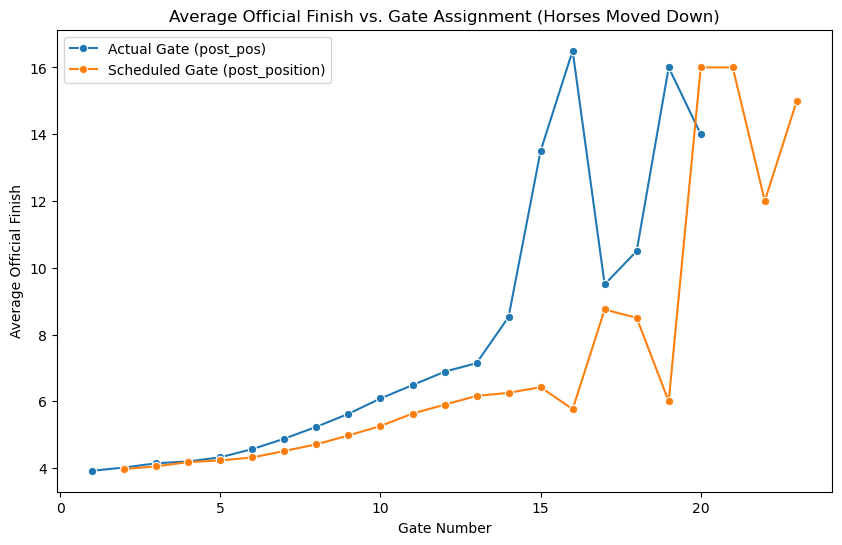

In [225]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Use your dataframe that contains only horses that were moved down
df_down = post_pos_change_down

# Compute average official finish by scheduled gate (post_pos)
avg_by_scheduled = df_down.groupby('post_pos')['official_fin'].mean().reset_index()

# Compute average official finish by actual gate (post_position)
avg_by_actual = df_down.groupby('post_position')['official_fin'].mean().reset_index()

plt.figure(figsize=(10, 6))

# Plot the average official finish vs. actual gate
sns.lineplot(data=avg_by_scheduled, x='post_pos', y='official_fin', marker='o', label='Actual Gate (post_pos)')

# Plot the average official finish vs. actual gate
sns.lineplot(data=avg_by_actual, x='post_position', y='official_fin', marker='o', label='Scheduled Gate (post_position)')

plt.title("Average Official Finish vs. Gate Assignment (Horses Moved Down)")
plt.xlabel("Gate Number")
plt.ylabel("Average Official Finish")
plt.legend()
plt.show()

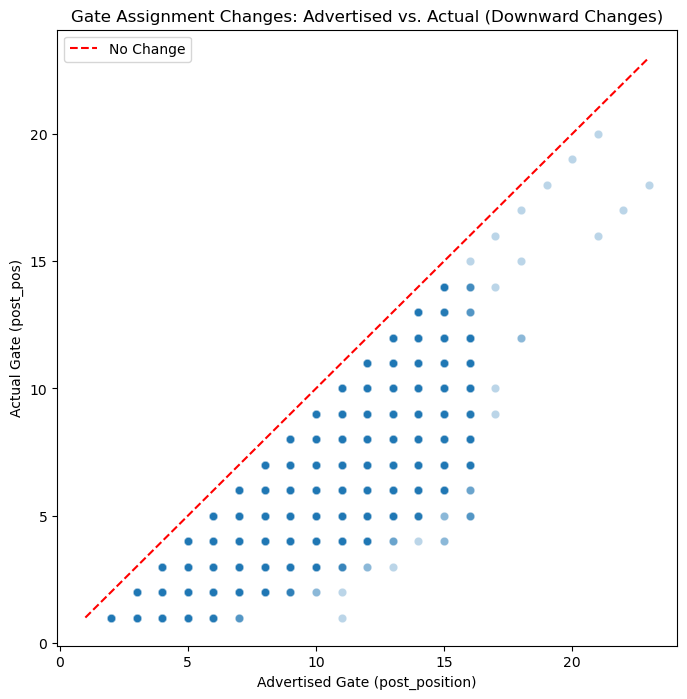

In [227]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the PySpark DataFrame to Pandas (if not already a Pandas DataFrame)
if hasattr(post_pos_change_down, "toPandas"):
    df_down = post_pos_change_down.toPandas()
else:
    df_down = post_pos_change_down

plt.figure(figsize=(8,8))
sns.scatterplot(data=df_down, 
                x='post_position',  # Advertised gate number
                y='post_pos',       # Actual gate number
                alpha=0.3)

# Plot a reference line y=x to show no change
min_val = min(df_down['post_position'].min(), df_down['post_pos'].min())
max_val = max(df_down['post_position'].max(), df_down['post_pos'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='No Change')

plt.xlabel('Advertised Gate (post_position)')
plt.ylabel('Actual Gate (post_pos)')
plt.title('Gate Assignment Changes: Advertised vs. Actual (Downward Changes)')
plt.legend()
plt.show()

## Step 2: Visualize with a Heatmap

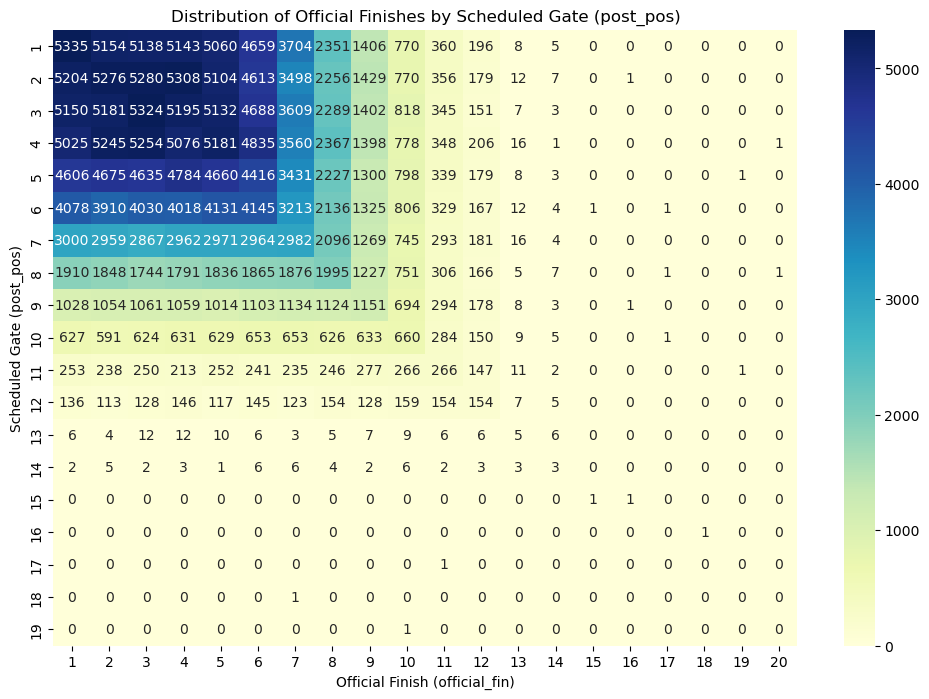

In [179]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(finish_distribution, annot=True, fmt='d', cmap="YlGnBu")
plt.title("Distribution of Official Finishes by Scheduled Gate (post_pos)")
plt.xlabel("Official Finish (official_fin)")
plt.ylabel("Scheduled Gate (post_pos)")
plt.show()

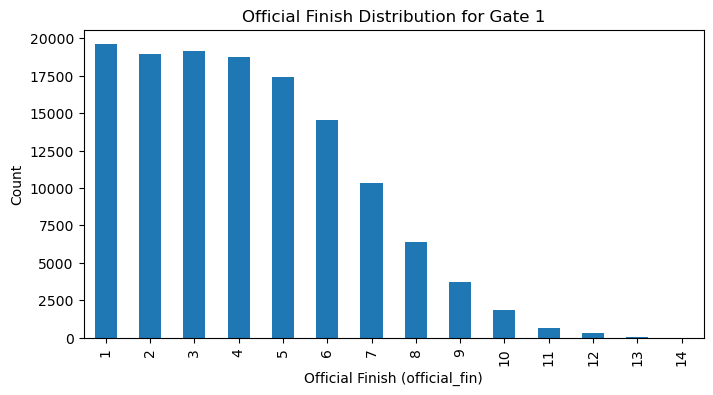

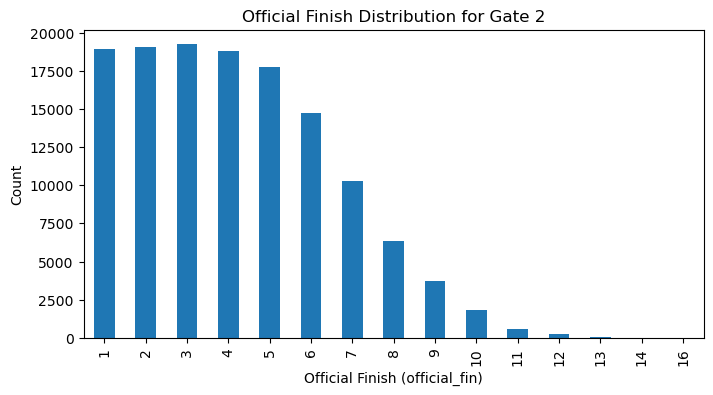

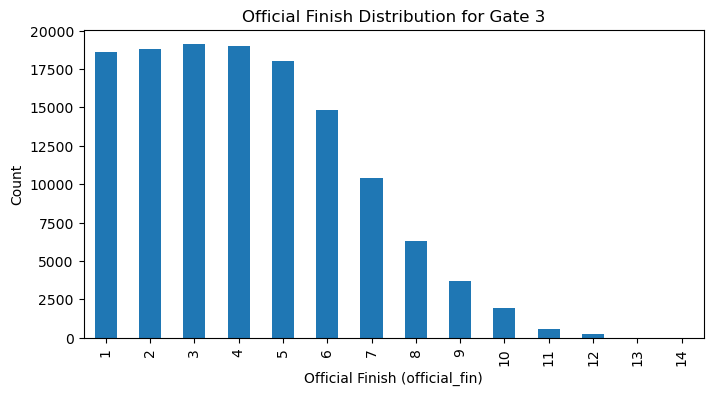

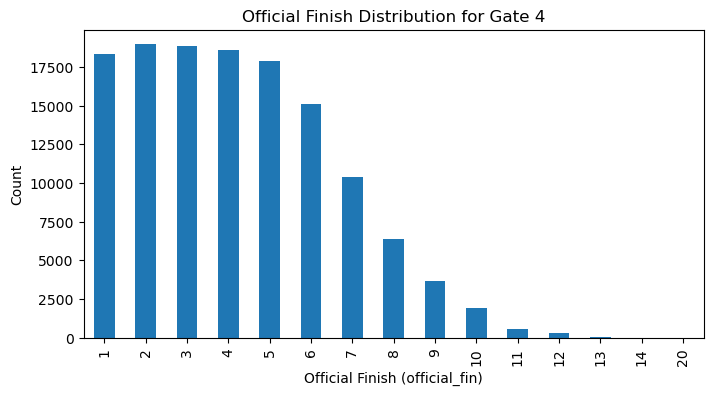

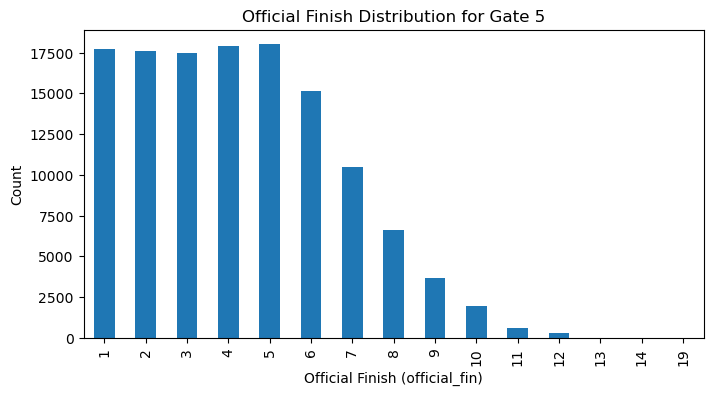

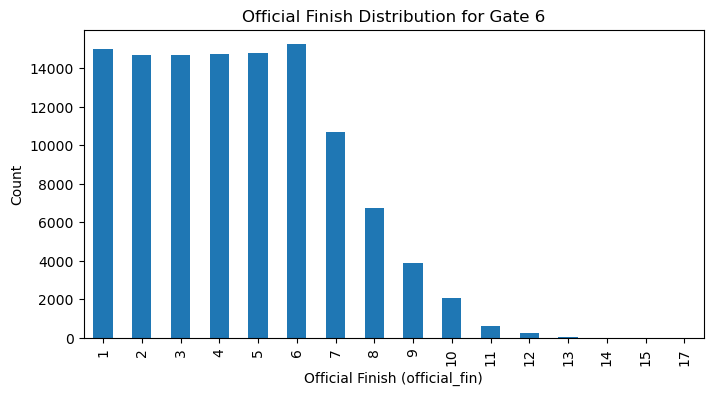

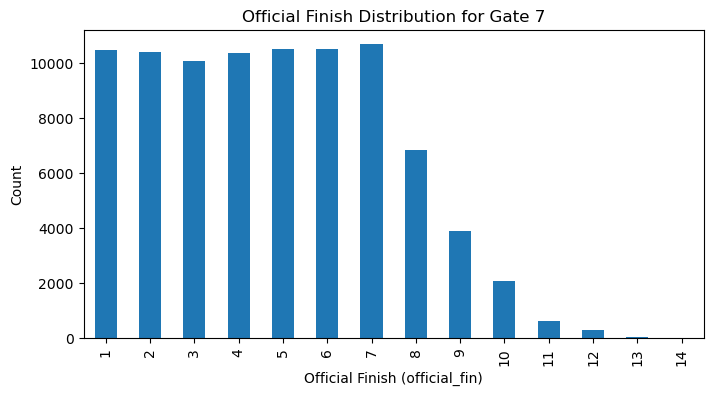

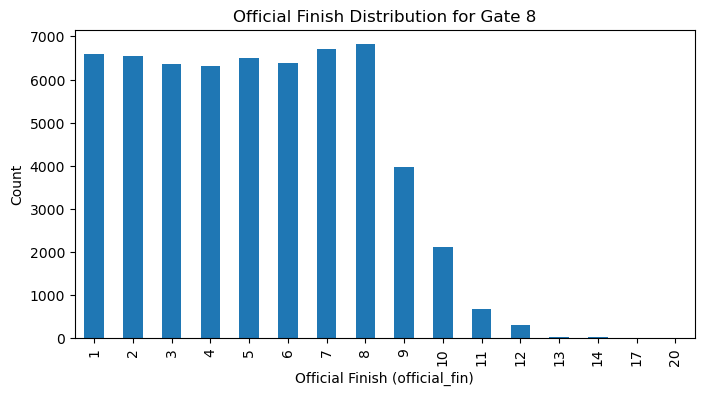

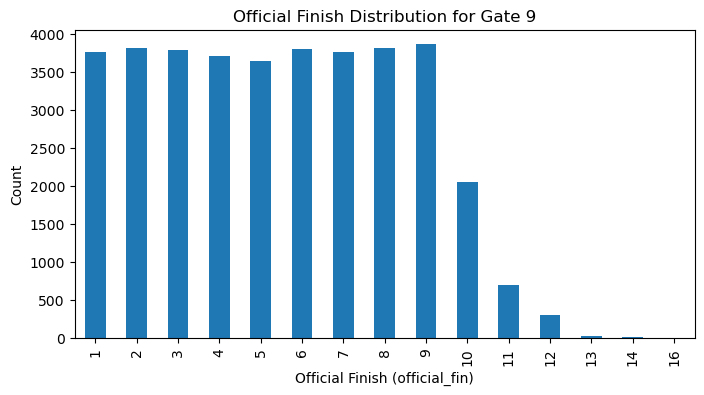

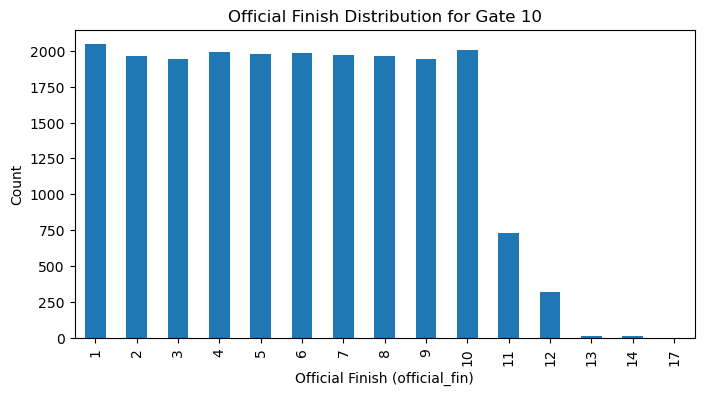

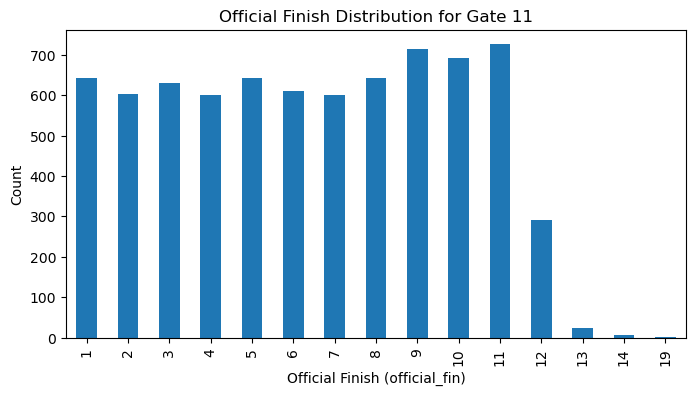

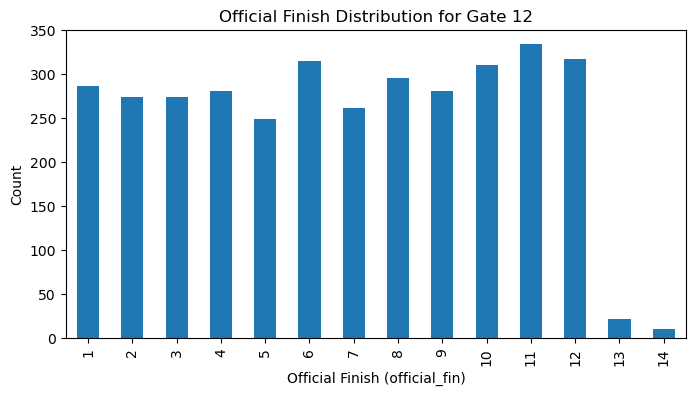

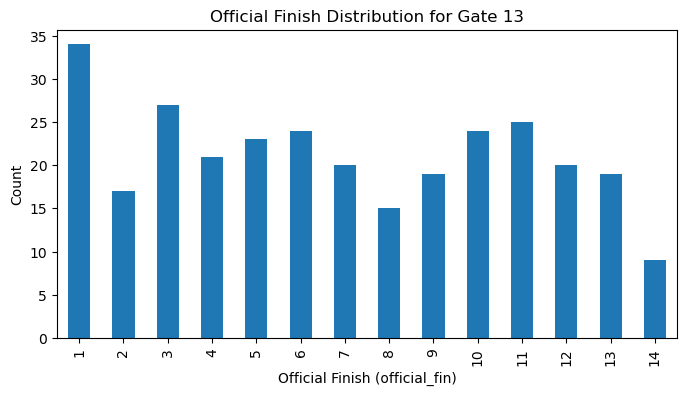

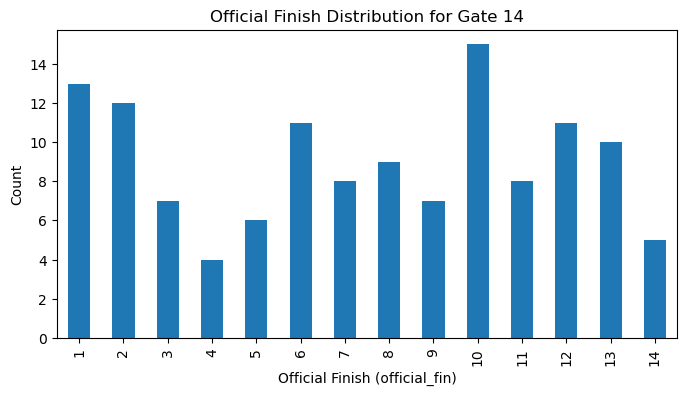

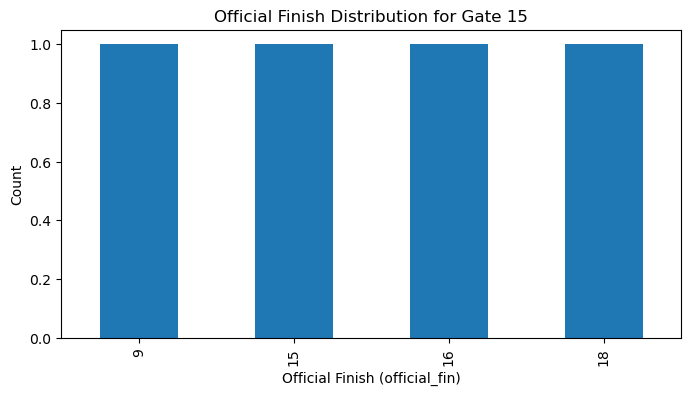

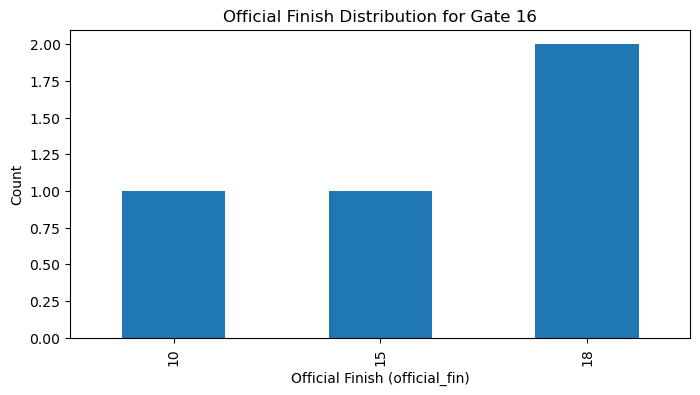

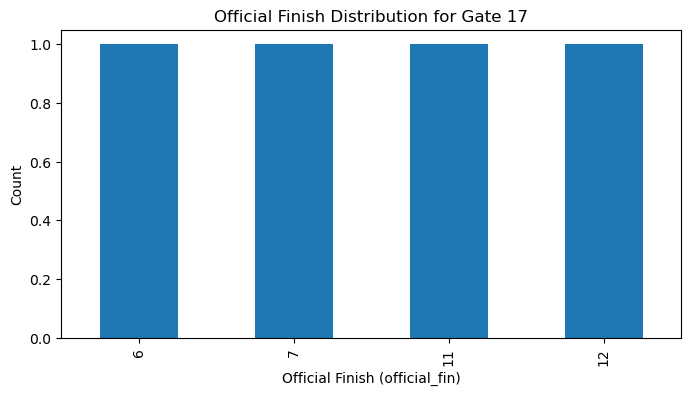

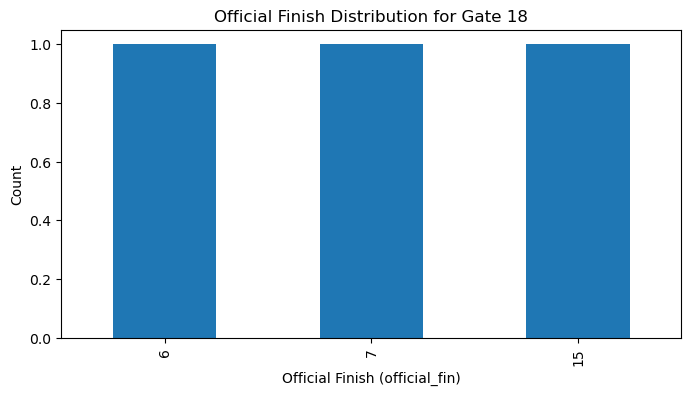

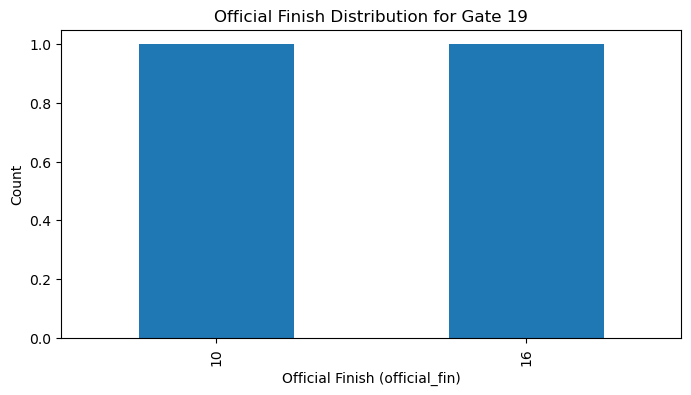

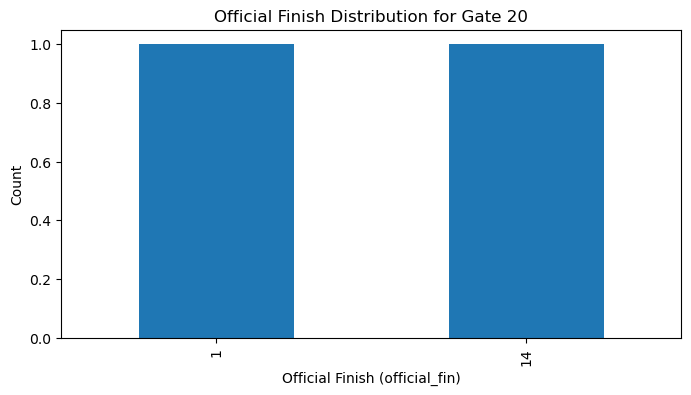

In [180]:
unique_gates = post_pos_change['post_pos'].unique()
unique_gates.sort()

for gate in unique_gates:
    subset = post_pos_pdf[post_pos_pdf['post_pos'] == gate]
    counts = subset['official_fin'].value_counts().sort_index()
    
    plt.figure(figsize=(8, 4))
    counts.plot(kind='bar')
    plt.title(f"Official Finish Distribution for Gate {gate}")
    plt.xlabel("Official Finish (official_fin)")
    plt.ylabel("Count")
    plt.show()

## Step 1: Compute the Number of Horses per Race

In [181]:
# Group by race identifiers and count the number of horses in each race
race_counts = post_pos_no_change.groupby(['course_cd', 'race_date', 'race_number']).size().reset_index(name='num_horses')
#print(race_counts.head())
print(race_counts['num_horses'].describe())

count    39297.000000
mean         7.394279
std          2.054362
min          4.000000
25%          6.000000
50%          7.000000
75%          9.000000
max         19.000000
Name: num_horses, dtype: float64


## Step 2: Visualize the Distribution with a Histogram

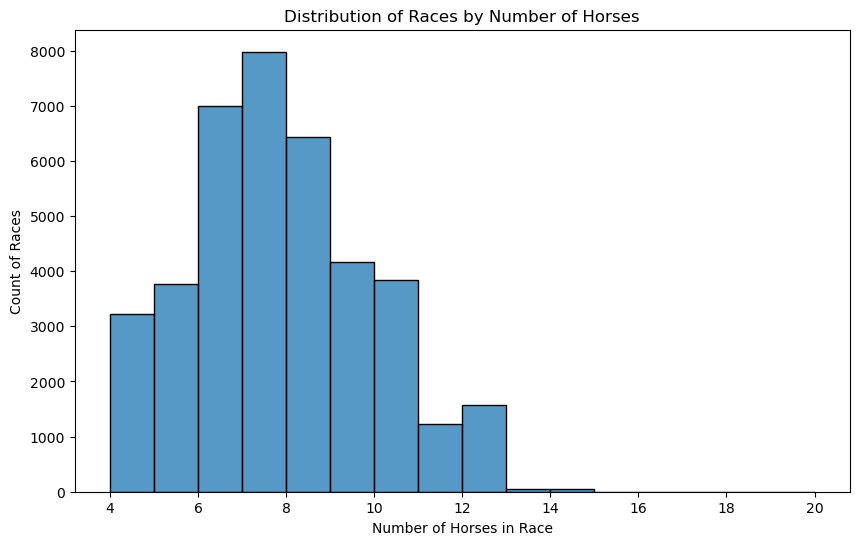

In [182]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
# Create bins from the minimum to the maximum number of horses observed
bins = range(race_counts['num_horses'].min(), race_counts['num_horses'].max() + 2)
sns.histplot(race_counts['num_horses'], bins=bins, kde=False)
plt.title("Distribution of Races by Number of Horses")
plt.xlabel("Number of Horses in Race")
plt.ylabel("Count of Races")
plt.show()

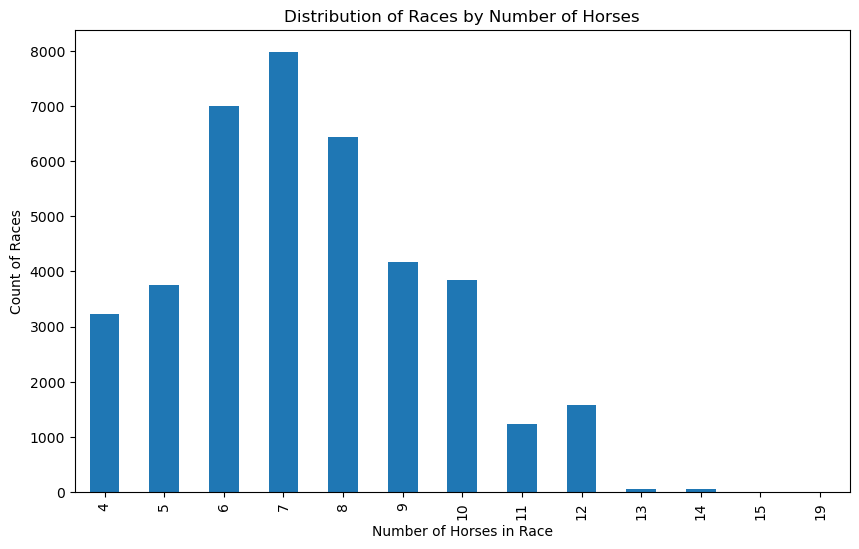

In [183]:
race_counts_freq = race_counts['num_horses'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
race_counts_freq.plot(kind='bar')
plt.title("Distribution of Races by Number of Horses")
plt.xlabel("Number of Horses in Race")
plt.ylabel("Count of Races")
plt.show()

## 1. Exploratory Analysis

### a. Summary Statistics by Gate

In [184]:
import pandas as pd

# Assuming post_pos_pdf is your DataFrame
gate_summary = post_pos_no_change.groupby('post_pos')['official_fin'].agg(['mean', 'median', 'std', 'count'])
print(gate_summary)

               mean  median       std  count
post_pos                                    
1          4.491308     4.0  2.538320  39289
2          4.465299     4.0  2.522463  39293
3          4.483254     4.0  2.513013  39294
4          4.511364     4.0  2.524825  39291
5          4.557373     4.0  2.541297  36062
6          4.674550     5.0  2.586311  32306
7          4.906476     5.0  2.683812  25309
8          5.284494     5.0  2.849461  17329
9          5.685311     6.0  2.994998  10906
10         5.943329     6.0  3.137071   6776
11         6.446860     7.0  3.408365   2898
12         6.784302     7.0  3.507986   1669
13         7.061856     6.0  3.947083     97
14         7.541667     7.0  3.803461     48
15        15.500000    15.5  0.707107      2
16        18.000000    18.0       NaN      1
17        11.000000    11.0       NaN      1
18         7.000000     7.0       NaN      1
19        10.000000    10.0       NaN      1


### b. Boxplots


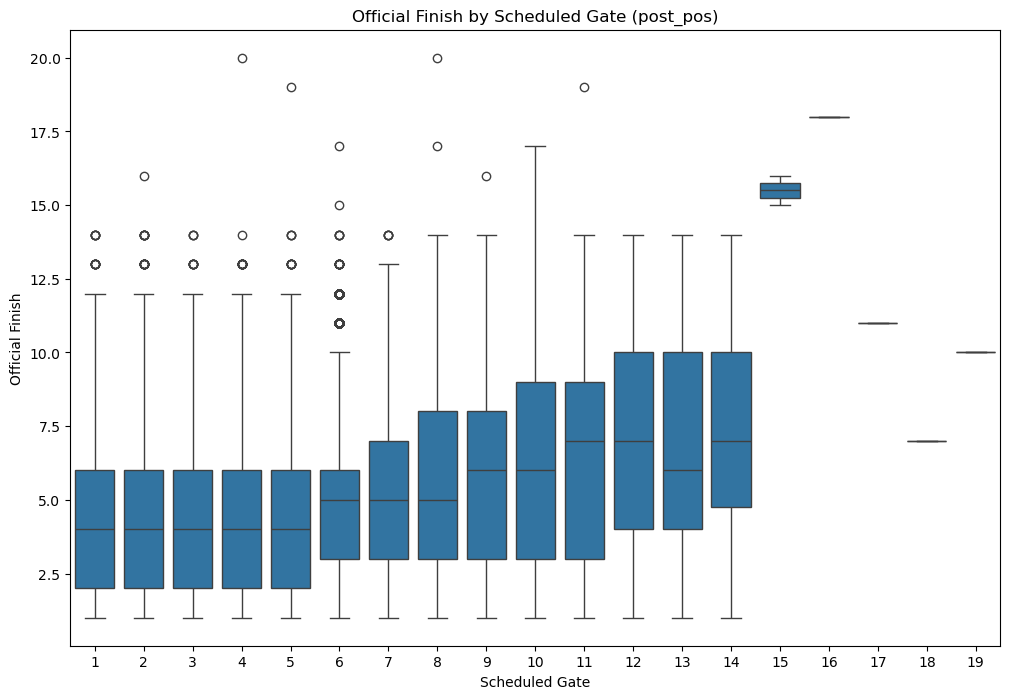

In [185]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.boxplot(x='post_position', y='official_fin', data=post_pos_no_change)
plt.title("Official Finish by Scheduled Gate (post_pos)")
plt.xlabel("Scheduled Gate")
plt.ylabel("Official Finish")
plt.show()

## 2. Statistical Testing

### a. ANOVA

You can run an Analysis of Variance (ANOVA) to test whether there is a significant difference in official finish among the different gates.

In [186]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Treat post_pos as a categorical variable.
model = smf.ols('official_fin ~ C(post_pos)', data=post_pos_change).fit()
anova_results = sm.stats.anova_lm(model, typ=2)
print(anova_results)

                    sum_sq        df           F  PR(>F)
C(post_pos)   46053.318585      19.0  374.365938     0.0
Residual     733814.936430  113338.0         NaN     NaN


### b. Regression Analysis

In [187]:
model2 = smf.ols('official_fin ~ post_pos', data=post_pos_change).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:           official_fin   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     6309.
Date:                Fri, 21 Mar 2025   Prob (F-statistic):               0.00
Time:                        00:16:48   Log-Likelihood:            -2.6709e+05
No. Observations:              113358   AIC:                         5.342e+05
Df Residuals:                  113356   BIC:                         5.342e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3290      0.018    186.751      0.0

## 3. Deriving Correction Factors

Once you’ve determined that there is a significant effect, you can derive a correction factor for each gate. For example, if horses from gate 10 finish on average 1.5 positions worse than the overall average, you might subtract 1.5 from your model’s predicted finish for horses assigned gate 10.

In [158]:
# Calculate average finish for each gate
correction_factors = post_pos_no_change.groupby('post_pos')['official_fin'].mean().reset_index()
correction_factors.rename(columns={'official_fin': 'avg_official_fin'}, inplace=True)

# Calculate overall mean finish (or you can compare to a baseline gate, e.g., gate 1)
overall_mean = post_pos_no_change['official_fin'].mean()
correction_factors['correction'] = correction_factors['avg_official_fin'] - overall_mean

print(correction_factors)

    post_pos  avg_official_fin  correction
0          1          4.491308   -0.223025
1          2          4.465299   -0.249034
2          3          4.483254   -0.231079
3          4          4.511364   -0.202969
4          5          4.557373   -0.156960
5          6          4.674550   -0.039784
6          7          4.906476    0.192143
7          8          5.284494    0.570161
8          9          5.685311    0.970977
9         10          5.943329    1.228996
10        11          6.446860    1.732527
11        12          6.784302    2.069969
12        13          7.061856    2.347522
13        14          7.541667    2.827333
14        15         15.500000   10.785667
15        16         18.000000   13.285667
16        17         11.000000    6.285667
17        18          7.000000    2.285667
18        19         10.000000    5.285667


## 4. Incorporate Post-Prediction Adjustment

When making predictions for future races, you can merge the correction factors onto your prediction DataFrame and adjust the predicted finish accordingly:

In [159]:
predictions.head()

,course_cd,race_date,race_number,saddle_cloth_number,post_position,YetiRank_top_3_NDCG_top_4_score,YetiRank_top_3_NDCG_top_4_score_pos,YetiRank_top_3_NDCG_top_4_rank
0,TFG,2025-03-20 00:00:00,2.0,1,1,1.228445,0.591864,1
1,TFG,2025-03-20 00:00:00,3.0,4,4,0.911407,0.100000,1
2,TFG,2025-03-20 00:00:00,4.0,5,5,1.252209,0.469874,2
3,TFG,2025-03-20 00:00:00,4.0,2,2,1.030660,0.248325,3
4,MVR,2025-03-18 00:00:00,2.0,2,2,1.048487,0.100000,6


In [160]:
import pandas as pd

# Assume predictions_df is your predictions DataFrame and correction_factors is already computed
# correction_factors has columns: 'post_pos' and 'correction'

# Merge the correction factors with predictions based on the scheduled gate.
# Here, predictions_df has the column 'post_position' which we align with 'post_pos' from correction_factors.
predictions = predictions.merge(correction_factors[['post_pos', 'correction']],
                                      left_on='post_position', right_on='post_pos', how='left')

# For clarity, let's define the baseline predicted finish.
# In this case, we assume that 'YetiRank_top_3_NDCG_top_4_rank' represents the predicted finishing order.
predictions['predicted_finish'] = predictions['YetiRank_top_3_NDCG_top_4_rank']

# Apply the post-prediction adjustment.
# The idea is that if, for example, gate 10 has a correction factor of +1.14,
# then the adjusted prediction is: predicted_finish + correction.
predictions['adjusted_prediction'] = predictions['predicted_finish'] + predictions['correction']

# Optionally, drop the temporary merge column 'post_pos'
predictions.drop(columns=['post_pos'], inplace=True)

# Inspect a few rows of the final DataFrame to verify the adjustments:
print(predictions[['course_cd', 'race_date', 'race_number', 'saddle_cloth_number', 
                      'post_position', 'predicted_finish', 'correction', 'adjusted_prediction']].head())

  course_cd            race_date  race_number saddle_cloth_number  \
0       TFG  2025-03-20 00:00:00          2.0                   1   
1       TFG  2025-03-20 00:00:00          3.0                   4   
2       TFG  2025-03-20 00:00:00          4.0                   5   
3       TFG  2025-03-20 00:00:00          4.0                   2   
4       MVR  2025-03-18 00:00:00          2.0                   2   

   post_position  predicted_finish  correction  adjusted_prediction  
0              1                 1   -0.223025             0.776975  
1              4                 1   -0.202969             0.797031  
2              5                 2   -0.156960             1.843040  
3              2                 3   -0.249034             2.750966  
4              2                 6   -0.249034             5.750966  


In [161]:
# Assume post_pos_no_change is your pandas DataFrame loaded from your historical data
# Let's compute the finish gap:
post_pos_no_change['finish_gap'] = post_pos_no_change['official_fin'] - post_pos_no_change['post_pos']

# See some summary statistics:
print(post_pos_no_change[['post_pos', 'official_fin', 'finish_gap']].describe())

            post_pos   official_fin     finish_gap
count  290573.000000  290573.000000  290573.000000
mean        4.483262       4.714333       0.231071
std         2.578272       2.654801       3.439991
min         1.000000       1.000000     -13.000000
25%         2.000000       3.000000      -2.000000
50%         4.000000       4.000000       0.000000
75%         6.000000       7.000000       3.000000
max        19.000000      20.000000      16.000000


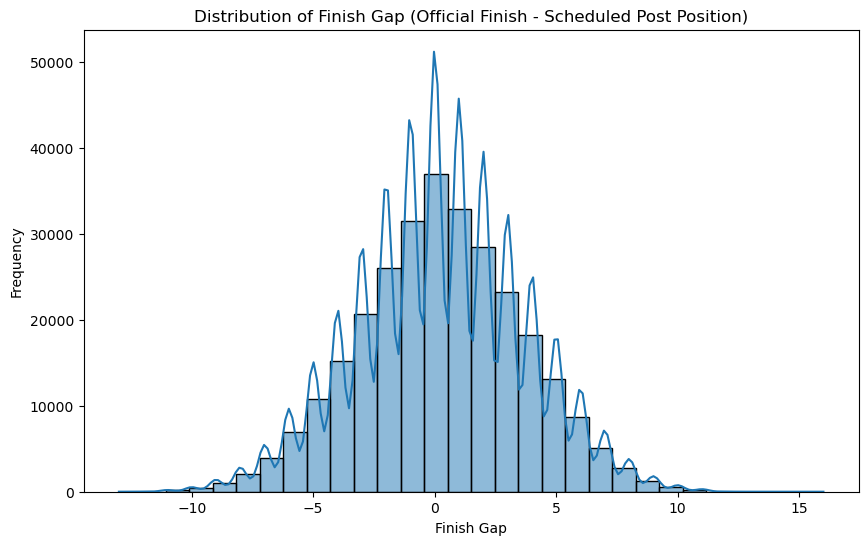

In [162]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(post_pos_no_change['finish_gap'], bins=30, kde=True)
plt.title('Distribution of Finish Gap (Official Finish - Scheduled Post Position)')
plt.xlabel('Finish Gap')
plt.ylabel('Frequency')
plt.show()

In [163]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

# OLS regression: finish_gap as a function of scheduled post position
model = smf.ols('finish_gap ~ C(post_pos)', data=post_pos_no_change).fit()
print(model.summary())

# ANOVA to see if there are statistically significant differences among the groups:
anova_results = sm.stats.anova_lm(model, typ=2)
print(anova_results)

                            OLS Regression Results                            
Dep. Variable:             finish_gap   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                 1.169e+04
Date:                Fri, 21 Mar 2025   Prob (F-statistic):               0.00
Time:                        00:08:56   Log-Likelihood:            -6.9217e+05
No. Observations:              290573   AIC:                         1.384e+06
Df Residuals:                  290554   BIC:                         1.385e+06
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             3.4913      0.01

In [164]:
# Calculate the average finish gap per scheduled post position
correction_factors = post_pos_no_change.groupby('post_pos')['finish_gap'].mean().reset_index()
correction_factors.rename(columns={'finish_gap': 'avg_finish_gap'}, inplace=True)
print(correction_factors)

    post_pos  avg_finish_gap
0          1        3.491308
1          2        2.465299
2          3        1.483254
3          4        0.511364
4          5       -0.442627
5          6       -1.325450
6          7       -2.093524
7          8       -2.715506
8          9       -3.314689
9         10       -4.056671
10        11       -4.553140
11        12       -5.215698
12        13       -5.938144
13        14       -6.458333
14        15        0.500000
15        16        2.000000
16        17       -6.000000
17        18      -11.000000
18        19       -9.000000


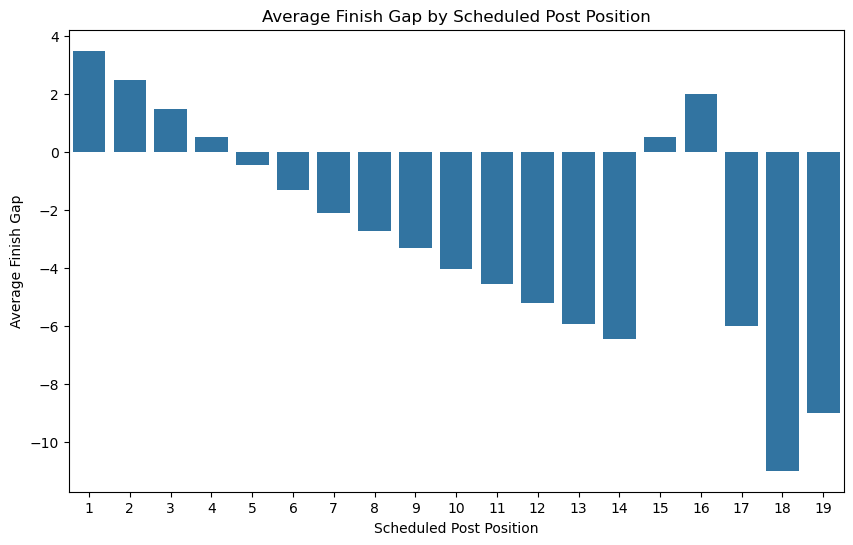

In [165]:
plt.figure(figsize=(10, 6))
sns.barplot(x='post_pos', y='avg_finish_gap', data=correction_factors)
plt.title('Average Finish Gap by Scheduled Post Position')
plt.xlabel('Scheduled Post Position')
plt.ylabel('Average Finish Gap')
plt.show()